In [1]:
!pip install statsmodels

In [2]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read in CSV file - convert to DataFrame
full_flight_data = pd.read_csv("../data/full_data_flightdelay.csv")
full_flight_data.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [4]:
# Inspect the data in our DataFrame
print(full_flight_data.info())
print(full_flight_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

### Important Columns
**`DEP_DEL15`:** returns binary response of `0` for NO flight delay (under 15 min) or `1` for a flight delay +15 min

**`DEP_TIME_BLK`:** distance to be flown by the departing aircraft (time block interval)

**`DISTANCE_GROUP`:** distance to be flown by the departing aircraft

**`SEGMENT_NUMBER`:** segment that tail number is on for the day

**`CONCURRENT_FLIGHTS`:** number of flights departing airport within same departure time block (tarmac traffic may cause delays)

**`CARRIER_NAME`:** airline/carrier for departing flight

**`PLANE_AGE`:** age of departing aircraft

**`DEPARTING_AIRPORT`:** departing airport for flight

**`PRCP`:** inches of precipitation for the day

**`SNOW`:** inches of snowfall for the day

**`SNWD`:** inches of snow on ground for the day

**`TMAX`:** max temperature for the day

**`AWND`:** max wind speed for the day


In [5]:
# Drop unnecessary columns for final DataFrame
flight_delay_df = full_flight_data.drop(columns=['NUMBER_OF_SEATS'])
flight_delay_df.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,Southwest Airlines Co.,13056,107363,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,Delta Air Lines Inc.,13056,73508,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,Delta Air Lines Inc.,13056,73508,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,Delta Air Lines Inc.,13056,73508,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,Spirit Air Lines,13056,15023,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


## Feature Engineering

In [6]:
# Create feature for weekends and holiday months (peak travel times)
flight_delay_df['IS_WEEKEND'] = flight_delay_df['DAY_OF_WEEK'].isin([6, 7]).astype(int)
flight_delay_df['IS_HOLIDAY'] = flight_delay_df['MONTH'].isin([7, 12]).astype(int)

## Airline/Carrier Analysis
**Correlation** between `CARRIER_NAME` (Airline Carriers) and `DEP_DEL15` (Departure Delay Over 15 Minutes)

In [7]:
# Convert DEP_DEL15 to integer to allow for count
flight_delay_df['DEP_DEL15'] = flight_delay_df['DEP_DEL15'].astype(int)

# Calculate 2019 delays for each carrier
delay_counts = flight_delay_df[flight_delay_df['DEP_DEL15'] == 1]['CARRIER_NAME'].value_counts()
ontime_counts = flight_delay_df[flight_delay_df['DEP_DEL15'] == 0]['CARRIER_NAME'].value_counts()

# Calculate percentage delay by total flights
percent_delay = ((delay_counts / (delay_counts + ontime_counts)) * 100).map('{:.2f}%'.format)

# DataFrame with 2019 flight data by carrier
carrier_flight_delays = pd.DataFrame({
    'Delayed': delay_counts,
    'On_Time': ontime_counts,
    '%_Delayed': percent_delay
}).fillna(0)

# Ensure 'Delayed' and 'On_Time' columns dtype=int
carrier_flight_delays['Delayed'] = carrier_flight_delays['Delayed'].astype(int)
carrier_flight_delays['On_Time'] = carrier_flight_delays['On_Time'].astype(int)

# Print carrier delay counts with percentage of delayed flights
print(carrier_flight_delays)

                              Delayed  On_Time %_Delayed
CARRIER_NAME                                            
Alaska Airlines Inc.            39417   199920    16.47%
Allegiant Air                    8072    34564    18.93%
American Airlines Inc.         181350   722290    20.07%
American Eagle Airlines Inc.    41153   187639    17.99%
Atlantic Southeast Airlines     23004    76040    23.23%
Comair Inc.                     42687   176637    19.46%
Delta Air Lines Inc.           137361   800985    14.64%
Endeavor Air Inc.               35641   168186    17.49%
Frontier Airlines Inc.          31536    89336    26.09%
Hawaiian Airlines Inc.           6521    68377     8.71%
JetBlue Airways                 68480   201116    25.40%
Mesa Airlines Inc.              34525   143075    19.44%
Midwest Airline, Inc.           49163   250991    16.38%
SkyWest Airlines Inc.          104124   480080    17.82%
Southwest Airlines Co.         271281  1025048    20.93%
Spirit Air Lines               

AttributeError: 'numpy.int64' object has no attribute 'startswith'

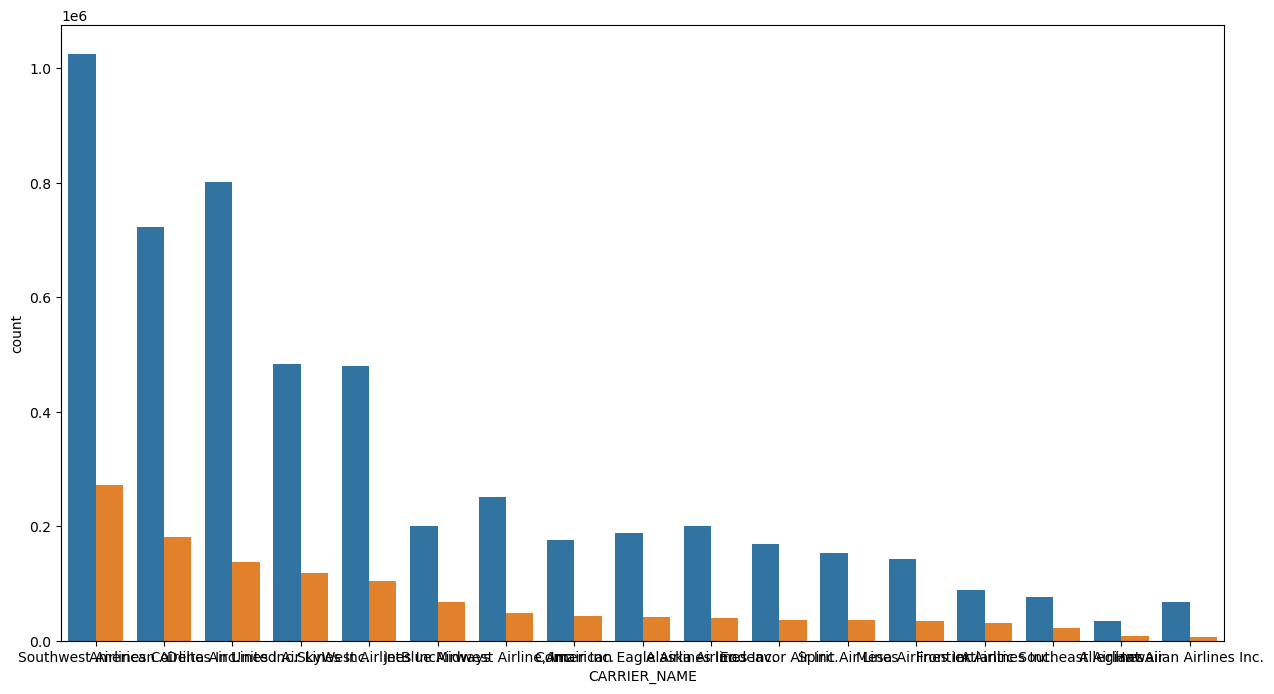

In [8]:
# Order carriers by number of delays
carrier_order = delay_counts.index

# Create the plot
plt.figure(figsize=(15, 8))
sns.countplot(x='CARRIER_NAME', hue='DEP_DEL15', data=flight_delay_df, order=carrier_order)
plt.xticks(rotation=80)
plt.title('Delays by Carrier (2019)', fontsize=16)
plt.xlabel('Carrier Name', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Update legend
plt.legend(title='Flight Status', labels=['No Delay', 'Delay'])
# Adjust layout
plt.tight_layout()

# Save as png in images folder
plt.savefig('../images/countplot_carrierdelays.png')
            
# Show the plot
plt.show()

#Cant figure out how to adjust the count boundaries (showing 0-1 for delay or no delay, rather than the total flights categorized as each)

In [9]:
# Convert DEP_DEL15 to categorical
flight_delay_df['DEP_DEL15_CAT'] = flight_delay_df['DEP_DEL15'].map({0: 'No Delay', 1: 'Delay'})

# Verify conversion
flight_delay_df.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,...,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,IS_WEEKEND,IS_HOLIDAY,DEP_DEL15_CAT
0,1,7,0,0800-0859,2,1,25,Southwest Airlines Co.,13056,107363,...,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,1,0,No Delay
1,1,7,0,0700-0759,7,1,29,Delta Air Lines Inc.,13056,73508,...,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,1,0,No Delay
2,1,7,0,0600-0659,7,1,27,Delta Air Lines Inc.,13056,73508,...,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,1,0,No Delay
3,1,7,0,0600-0659,9,1,27,Delta Air Lines Inc.,13056,73508,...,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,1,0,No Delay
4,1,7,0,0001-0559,7,1,10,Spirit Air Lines,13056,15023,...,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,1,0,No Delay


FileNotFoundError: [Errno 2] No such file or directory: '../images/heatmap_carrierdelays.png'

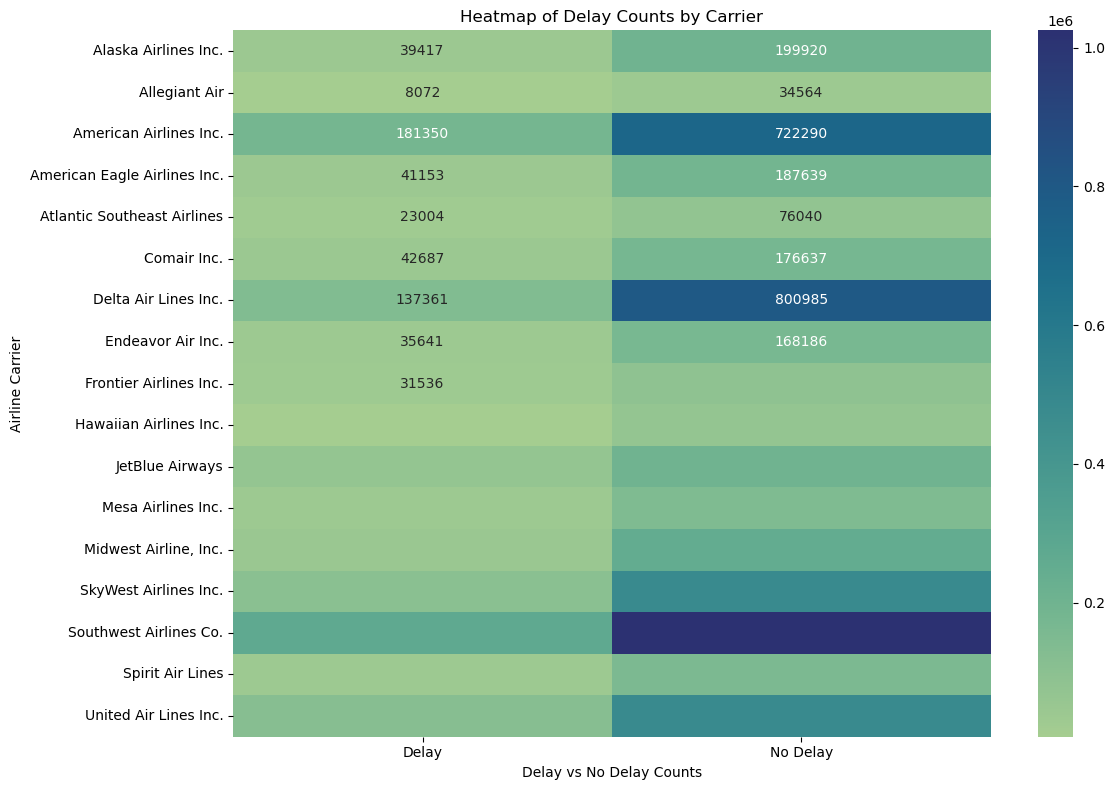

In [10]:
# Heatmap to visualize correlation between airline carriers and delays
count_matrix = pd.crosstab(flight_delay_df['CARRIER_NAME'], flight_delay_df['DEP_DEL15_CAT'])

plt.figure(figsize=(12, 8))
sns.heatmap(count_matrix, annot=True, fmt='d', cmap='crest')
plt.title('Heatmap of Delay Counts by Carrier')
plt.xlabel('Delay vs No Delay Counts')
plt.ylabel('Airline Carrier')
plt.tight_layout()

# Save as png in images folder
plt.savefig('../images/heatmap_carrierdelays.png')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../images/heatmap_top10carrierdelays.png'

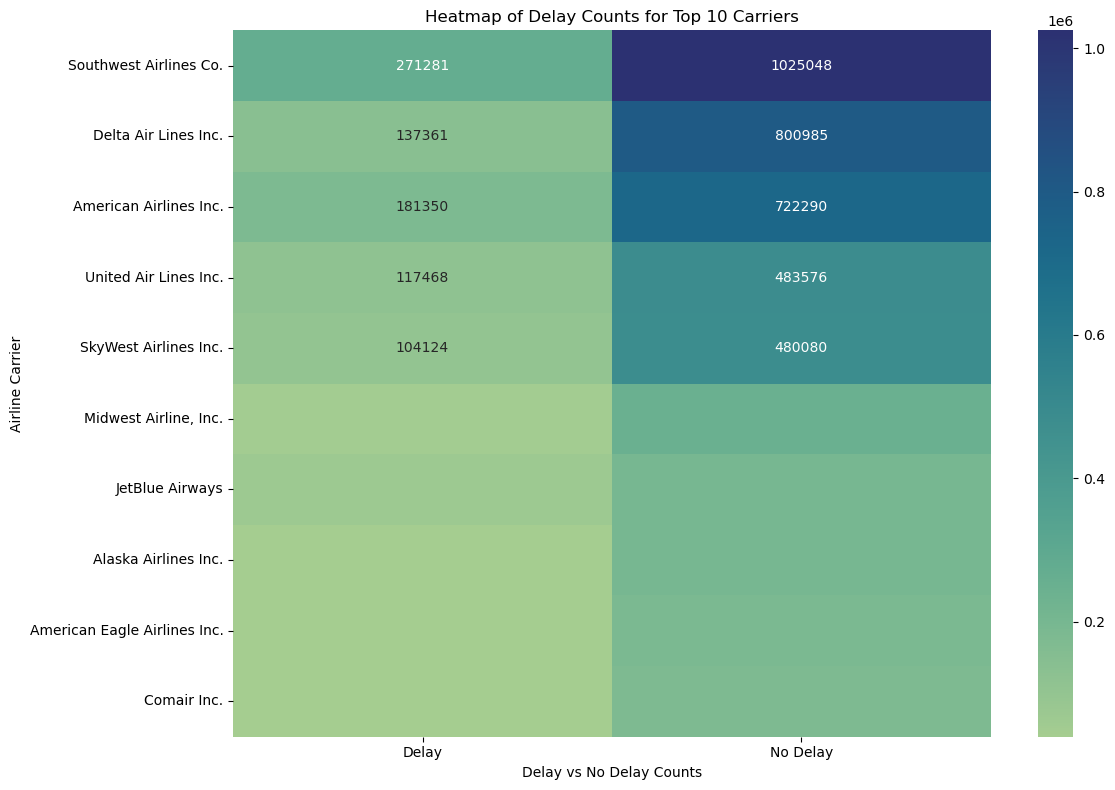

In [15]:
# Visualize correlation between top 10 carriers and delays
top_carriers = flight_delay_df['CARRIER_NAME'].value_counts().nlargest(10).index
count_matrix_top = pd.crosstab(flight_delay_df['CARRIER_NAME'], flight_delay_df['DEP_DEL15_CAT'])
count_matrix_top = count_matrix_top.loc[top_carriers]

plt.figure(figsize=(12, 8))
sns.heatmap(count_matrix_top, annot=True, fmt='d', cmap='crest')
plt.title('Heatmap of Delay Counts for Top 10 Carriers')
plt.xlabel('Delay vs No Delay Counts')
plt.ylabel('Airline Carrier')
plt.tight_layout()

# Save as png in images folder
plt.savefig('../images/heatmap_top10carrierdelays.png')

plt.show()

In [16]:
# Further statistical tests to analyze correlation
contingency_table = pd.crosstab(flight_delay_df['CARRIER_NAME'], flight_delay_df['DEP_DEL15_CAT'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-square statistic: 36413.94584433001
p-value: 0.0


In [17]:
flight_delay_df.columns

Index(['MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'CARRIER_NAME',
       'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT',
       'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
       'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE',
       'LONGITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND',
       'IS_WEEKEND', 'IS_HOLIDAY', 'DEP_DEL15_CAT', 'DATE'],
      dtype='object')

In [18]:
# Convert DEP_DEL15 to integer to allow for count
flight_delay_df['DEP_DEL15'] = flight_delay_df['DEP_DEL15'].astype(int)

# Calculate 2019 delays for each carrier
airport_delay_counts = flight_delay_df[flight_delay_df['DEP_DEL15'] == 1]['DEPARTING_AIRPORT'].value_counts()
airport_ontime_counts = flight_delay_df[flight_delay_df['DEP_DEL15'] == 0]['DEPARTING_AIRPORT'].value_counts()

# Calculate percentage delay by total flights
airport_percent_delay = ((airport_delay_counts / (airport_delay_counts + airport_ontime_counts)) * 100).map('{:.2f}%'.format)

# DataFrame with 2019 flight data by carrier
airport_flight_delays = pd.DataFrame({
    'Delayed': airport_delay_counts,
    'On_Time': airport_ontime_counts,
    '%_Delayed': airport_percent_delay
}).fillna(0)

# Ensure 'Delayed' and 'On_Time' columns dtype=int
airport_flight_delays['Delayed'] = airport_flight_delays['Delayed'].astype(int)
airport_flight_delays['On_Time'] = airport_flight_delays['On_Time'].astype(int)

# Sort by %_Delayed in descending order
airport_flight_delays = airport_flight_delays.sort_values('%_Delayed', ascending=True)

# Print carrier delay counts with percentage of delayed flights
airport_flight_delays.head()

,Delayed,On_Time,%_Delayed
DEPARTING_AIRPORT,,,
Honolulu International,5265,46753,10.12%
Kahului Airport,2937,24277,10.79%
Boise Air Terminal,2353,16583,12.43%
Portland International,7860,54136,12.68%
Long Beach Daugherty Field,1914,12754,13.05%


In [19]:
# Convert MONTH and DAY_OF_WEEK to a date
flight_delay_df['DATE'] = pd.to_datetime('2019-' + flight_delay_df['MONTH'].astype(str) + '-' + flight_delay_df['DAY_OF_WEEK'].astype(str), format='%Y-%m-%d')

# Calculate monthly delay rates for each airport
monthly_delay_rates = flight_delay_df.groupby([flight_delay_df['DATE'].dt.to_period('M'), 'DEPARTING_AIRPORT'])['DEP_DEL15'].mean().unstack()
print(monthly_delay_rates)

DEPARTING_AIRPORT  Adams Field  Albany International  \
DATE                                                   
2019-01                    NaN                   NaN   
2019-02                    NaN                   NaN   
2019-03               0.147239              0.135957   
2019-04               0.153363                   NaN   
2019-05               0.192006              0.160360   
2019-06               0.216006              0.198198   
2019-07               0.155985              0.228101   
2019-08               0.166799              0.195443   
2019-09               0.120851                   NaN   
2019-10               0.159019                   NaN   
2019-11               0.124564                   NaN   
2019-12               0.155375                   NaN   

DEPARTING_AIRPORT  Albuquerque International Sunport  Anchorage International  \
DATE                                                                            
2019-01                                     0.115702 

In [20]:
## Statistical tests

# Chi-square test of independence
chi2, p_value, dof, expected = chi2_contingency(airport_delay_counts)
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

# Cramer's V to measure strength of association
n = airport_delay_counts.sum().sum()
min_dim = min(airport_delay_counts.shape) - 1
cramer_v = np.sqrt(chi2 / (n * min_dim))
print(f"Cramer's V: {cramer_v}")

# Top and bottom airports by delay rate
print("\nTop 5 airports with highest delay rates:")
print(airport_flight_delays['%_Delayed'].head())
print("\nTop 5 airports with lowest delay rates:")
print(airport_flight_delays['%_Delayed'].tail()) # showing oddly sorted - will check back later

Chi-square statistic: 0.0
p-value: 1.0
Cramer's V: 0.0

Top 5 airports with highest delay rates:
DEPARTING_AIRPORT
Honolulu International        10.12%
Kahului Airport               10.79%
Boise Air Terminal            12.43%
Portland International        12.68%
Long Beach Daugherty Field    13.05%
Name: %_Delayed, dtype: object

Top 5 airports with lowest delay rates:
DEPARTING_AIRPORT
Chicago Midway International    26.54%
Puerto Rico International       27.38%
Keahole                          7.96%
Lihue Airport                    8.63%
Anchorage International          9.93%
Name: %_Delayed, dtype: object


FileNotFoundError: [Errno 2] No such file or directory: '../images/yearly_delayrates_top5airports.png'

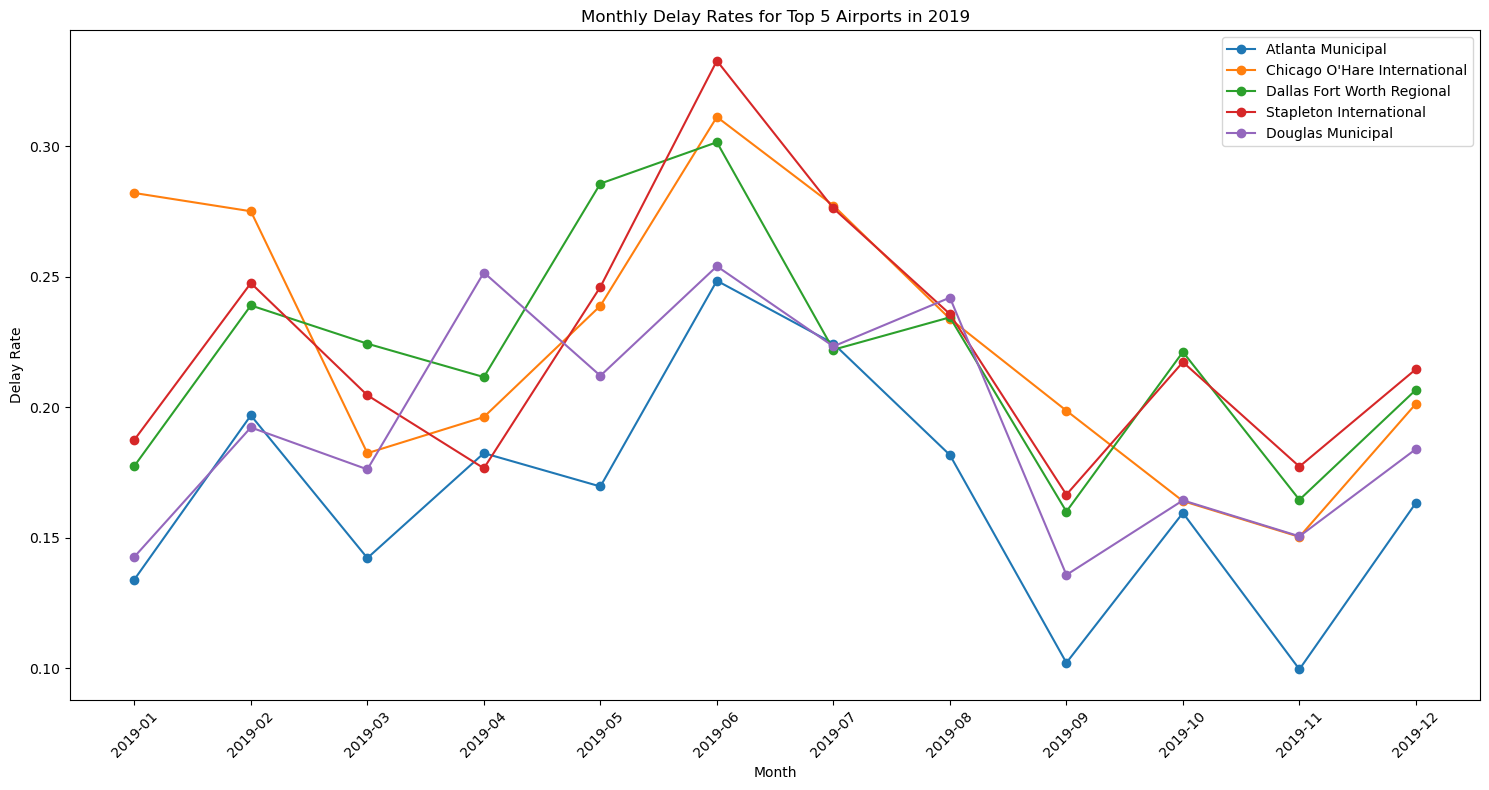

In [21]:
# Select top 5 airports by total flights for more visible graphing
top_airports = flight_delay_df['DEPARTING_AIRPORT'].value_counts().nlargest(5).index

# Plot monthly delay rates
plt.figure(figsize=(15, 8))
for airport in top_airports:
    plt.plot(monthly_delay_rates.index.astype(str), monthly_delay_rates[airport], label=airport, marker='o')

plt.title('Monthly Delay Rates for Top 5 Airports in 2019')
plt.xlabel('Month')
plt.ylabel('Delay Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save as png in images folder
plt.savefig('../images/yearly_delayrates_top5airports.png')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../images/heatmap_monthlyairportdelays.png'

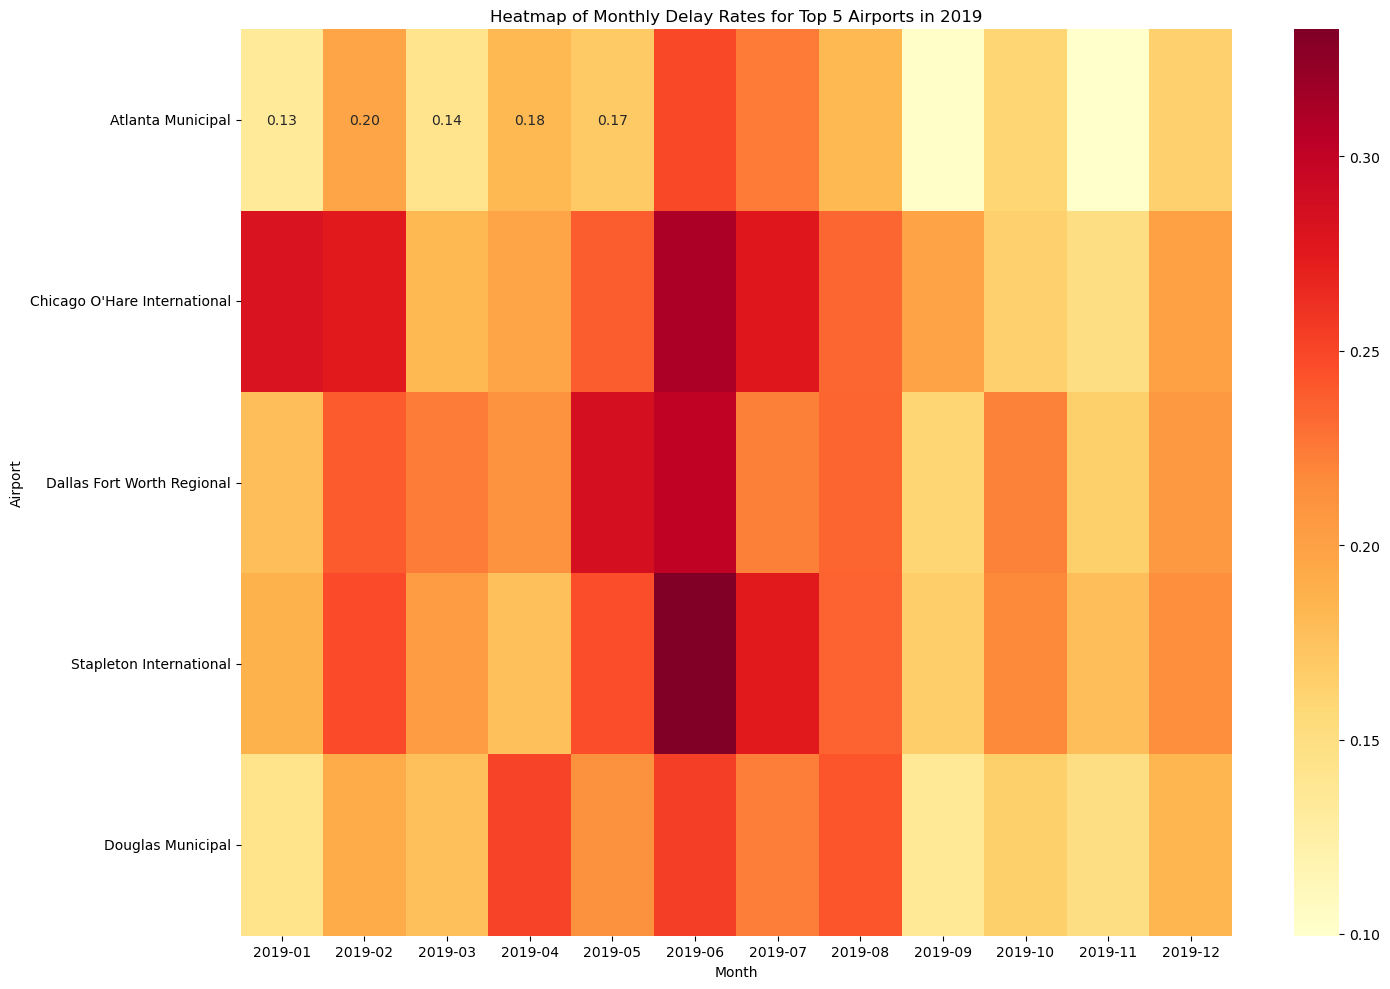

In [22]:
# Heatmap of monthly delay rates
plt.figure(figsize=(15, 10))
sns.heatmap(monthly_delay_rates[top_airports].T, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Heatmap of Monthly Delay Rates for Top 5 Airports in 2019')
plt.xlabel('Month')
plt.ylabel('Airport')
plt.tight_layout()

# Save as png in images folder
plt.savefig('../images/heatmap_monthlyairportdelays.png')

plt.show()

### Import and Clean Airport Dataset 
Compare the list of airports available in our 2019 dataset to our imported airport csv, removing the US airports that are not used to train our model. (Preprocessed airport data to populate an html dropdown)

In [23]:
# List of departing airport names
airport_list = flight_delay_df['DEPARTING_AIRPORT'].unique()

# Convert numpy array to a list and sort for better readability
airport_list = list(airport_list)
airport_list.sort()

# Print the list of airport names
print(airport_list)

['Adams Field', 'Albany International', 'Albuquerque International Sunport', 'Anchorage International', 'Atlanta Municipal', 'Austin - Bergstrom International', 'Birmingham Airport', 'Boise Air Terminal', 'Bradley International', 'Charleston International', 'Chicago Midway International', "Chicago O'Hare International", 'Cincinnati/Northern Kentucky International', 'Cleveland-Hopkins International', 'Dallas Fort Worth Regional', 'Dallas Love Field', 'Des Moines Municipal', 'Detroit Metro Wayne County', 'Douglas Municipal', 'El Paso International', 'Eppley Airfield', 'Fort Lauderdale-Hollywood International', 'Friendship International', 'General Mitchell Field', 'Greater Buffalo International', 'Greenville-Spartanburg', 'Hollywood-Burbank Midpoint', 'Honolulu International', 'Houston Intercontinental', 'Indianapolis Muni/Weir Cook', 'Jacksonville International', 'James M Cox/Dayton International', 'John F. Kennedy International', 'Kahului Airport', 'Kansas City International', 'Keahole'

In [24]:
# Read in Airport data - convert to DataFrame
us_airport_data = pd.read_csv("../data/airports.csv")
us_airport_data.head()

,IATA,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABQ,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194
1,ANC,Ted Stevens Anchorage International,Anchorage,AK,USA,61.174320,-149.996186
2,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
3,AUS,Austin-Bergstrom International,Austin,TX,USA,30.194533,-97.669872
4,BDL,Bradley International,Windsor Locks,CT,USA,41.938874,-72.683228


In [25]:
# Create new DF with combined/filtered airport data
decimals = 3  # Adjusting decimal to account for lat/long minor discrepencies

flight_delay_df['LATITUDE'] = flight_delay_df['LATITUDE'].round(decimals)
flight_delay_df['LONGITUDE'] = flight_delay_df['LONGITUDE'].round(decimals)
us_airport_data['LATITUDE'] = us_airport_data['LATITUDE'].round(decimals)
us_airport_data['LONGITUDE'] = us_airport_data['LONGITUDE'].round(decimals)

filtered_airport_data = us_airport_data[us_airport_data[['LATITUDE','LONGITUDE']]
.apply(tuple, 1)
.isin(flight_delay_df[['LATITUDE', 'LONGITUDE']]
.apply(tuple, 1))]

# Print filtered airport DataFrame
filtered_airport_data.head()

,IATA,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
4,BDL,Bradley International,Windsor Locks,CT,USA,41.939,-72.683
12,CLE,Cleveland-Hopkins Intl,Cleveland,OH,USA,41.411,-81.849
24,HNL,Honolulu International,Honolulu,HI,USA,21.319,-157.922
25,HOU,William P X,Houston,TX,USA,29.645,-95.279
31,LAS,McCarran International,Las Vegas,NV,USA,36.080,-115.152


In [26]:
# Check list of airports in merged df to check for missing values
filtered_airport_list = filtered_airport_data['AIRPORT'].unique

# Print the list of airport names
print(filtered_airport_list)

<bound method Series.unique of 4                   Bradley International
12                 Cleveland-Hopkins Intl
24                 Honolulu International
25                            William P X
31                 McCarran International
35              Kansas City International
43     Metropolitan Oakland International
47                  Ontario International
57                 Richmond International
59        Southwest Florida International
64            San Francisco International
73                   Tucson International
220         Kona International At Keahole
338           Northwest Arkansas Regional
Name: AIRPORT, dtype: object>


In [27]:
# Export filtered airport data as a CSV file
filtered_airport_data.to_csv("../data/airport_data.csv", index=False)

## Delay Probability by Peak Travel Times

FileNotFoundError: [Errno 2] No such file or directory: '../images/linechart_hourlydelayrates.png'

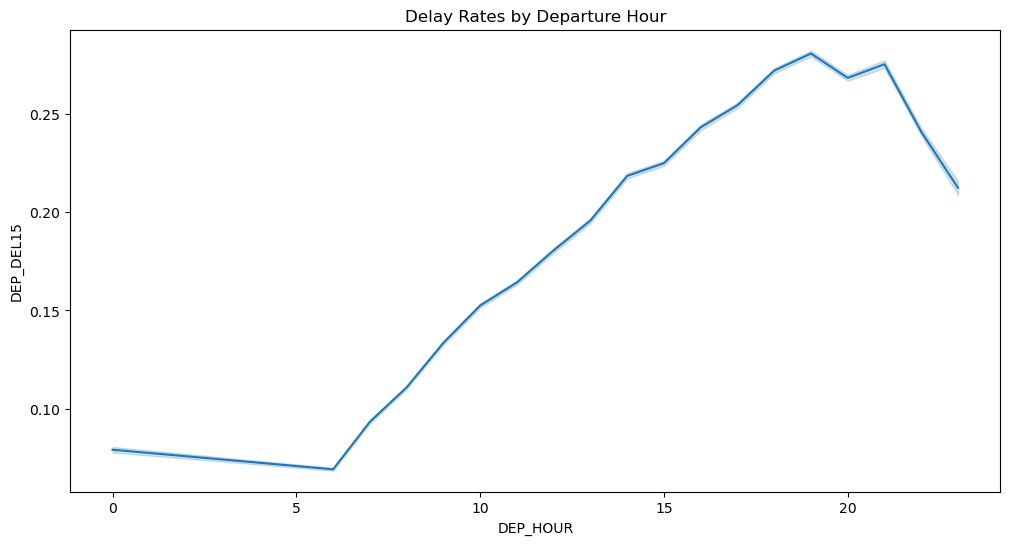

In [28]:
# Use line plot to visualize average peak travel times by hour
flight_delay_df['DEP_HOUR'] = flight_delay_df['DEP_TIME_BLK'].apply(lambda x: int(x.split('-')[0][:2]))

plt.figure(figsize=(12, 6))
sns.lineplot(x='DEP_HOUR', y='DEP_DEL15', data=flight_delay_df)
plt.title('Delay Rates by Departure Hour')

# Save as png in images folder
plt.savefig('../images/linechart_hourlydelayrates.png')

plt.show()

In [ ]:
# Mapping for days of the week
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4:'Thursday', 
               5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# Calculate delay rates for each day of the week
delay_rates = flight_delay_df.groupby('DAY_OF_WEEK')['DEP_DEL15'].mean().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(delay_rates.index, delay_rates.values)
plt.title('Flight Delay Rates by Day of Week in 2019')
plt.xlabel('Day of Week')
plt.ylabel('Delay Rate')
plt.ylim(0, delay_rates.max() * 1.1)  # Limit to 110% of max value for better visibility
plt.xticks(delay_rates.index, [day_mapping[day] for day in delay_rates.index])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
print(delay_rates)
# Save as png in images folder
plt.savefig('../images/barchart_dayofweekdelays.png')
plt.show()

In [ ]:
# Busiest days of the week
flight_counts = flight_delay_df['DAY_OF_WEEK'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(flight_counts.index, flight_counts.values)
plt.title('Number of Flights by Day of Week in 2019')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')

# Customize x-axis labels
plt.xticks(flight_counts.index, [day_mapping[day] for day in flight_counts.index])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',  # Format with commas for thousands
             ha='center', va='bottom')

plt.tight_layout()
# Save as png in images folder
plt.savefig('../images/barchart_dayofweek_flightcount.png')
plt.show()